In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import joblib
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Dataset_CP/mahal.csv')

In [ ]:
data.head()

,order no,order date,order time,brand,item group,item name,item sku,qty,currency,price,...,discount amount,amount,cost perunit,total cost,profit,comission,Country,ZIP Code,City,Provinsi
0,OL21010100002723,2021-01-01 00:00:00,2021-01-01 13:37:15,TORY BURCH,WOMEN BAGS,TORY BURCH 58025 PERRY LEATHER BP BLACK,192485268584,1,IDR,4250000.0,...,0.0,4250000.0,4735000.0,4735000.0,-485000.0,0.0,Indonesia,23241.0,Kota Banda Aceh,Aceh
1,OL21010100002724,2021-01-01 00:00:00,2021-01-01 14:01:32,KATE SPADE,Women Wallets,KATE SPADE WLRU6153 HOLLIE SPADE CLOVER GEO EM...,767883689936,1,IDR,1100000.0,...,0.0,1100000.0,868515.0,868515.0,231485.0,0.0,Indonesia,53274.0,Kabupaten Cilacap,Jawa Tengah
2,372721010100000200,2021-01-01 00:00:00,2021-01-01 14:21:33,KATE SPADE,WOMEN BAGS,KATE SPADE WKRO0068 SPADE LINK TOTE WHITE MULTI,767883816981,1,IDR,1550000.0,...,0.0,1550000.0,1221044.0,1221044.0,328956.0,0.0,NaN,NaN,NaN,NaN
3,OL21010100002725,2021-01-01 00:00:00,2021-01-01 14:35:11,MICHAEL KORS,Women Shoes,MICHAEL KORS FLAT SHOES STUD BROWN BLACK,190000125411,1,IDR,1400000.0,...,0.0,1400000.0,1124949.0,1124949.0,275051.0,0.0,Indonesia,17115.0,Kota Bekasi,Jawa Barat
4,OL21010100002726,2021-01-01 00:00:00,2021-01-01 15:18:21,KATE SPADE,WOMEN BAGS,MICHAEL KORS 35S0GXZM1B TEAGEN SMALL MESSENGER...,193599454603,1,IDR,1650000.0,...,0.0,1650000.0,1156925.0,1156925.0,493075.0,0.0,Indonesia,41360.0,Kabupaten Karawang,Jawa Barat


In [ ]:
data.isnull().sum()

,0
order no,1
order date,1
order time,1
brand,5
item group,1
item name,1
item sku,1
qty,0
currency,1
price,1


In [ ]:
data = data.interpolate(method='linear', axis=0, limit_direction='forward', limit=None)
data = data.fillna(method='bfill')

<ipython-input-6-c92736cadd97>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear', axis=0, limit_direction='forward', limit=None)
<ipython-input-6-c92736cadd97>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')


In [ ]:
columns_to_drop = [
    'order no', 'order date', 'order time', 'item sku', 'qty', 'currency',
    'profit', 'comission', 'Country', 'ZIP Code', 'City', 'Provinsi',
    'add-on price', 'discount percent', 'discount amount', 'amount', 'cost perunit', 'total cost'
]
data.drop(columns=columns_to_drop, inplace=True)
print(data.head())

          brand     item group  \
0    TORY BURCH     WOMEN BAGS   
1    KATE SPADE  Women Wallets   
2    KATE SPADE     WOMEN BAGS   
3  MICHAEL KORS    Women Shoes   
4    KATE SPADE     WOMEN BAGS   

                                           item name      price  
0            TORY BURCH 58025 PERRY LEATHER BP BLACK  4250000.0  
1  KATE SPADE WLRU6153 HOLLIE SPADE CLOVER GEO EM...  1100000.0  
2    KATE SPADE WKRO0068 SPADE LINK TOTE WHITE MULTI  1550000.0  
3           MICHAEL KORS FLAT SHOES STUD BROWN BLACK  1400000.0  
4  MICHAEL KORS 35S0GXZM1B TEAGEN SMALL MESSENGER...  1650000.0  


In [ ]:
data['merek'] = data['brand']

In [ ]:
data['Brand'] = data['item name']

In [ ]:
data.drop(columns=['item name','brand'], inplace=True)

In [ ]:
data = data.dropna(subset=['item group', 'merek'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 603 entries, 0 to 602
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item group  603 non-null    object 
 1   price       603 non-null    float64
 2   merek       603 non-null    object 
 3   Brand       603 non-null    object 
dtypes: float64(1), object(3)
memory usage: 23.6+ KB


In [ ]:
data.head()

,item group,price,merek,Brand
0,WOMEN BAGS,4250000.0,TORY BURCH,TORY BURCH 58025 PERRY LEATHER BP BLACK
1,Women Wallets,1100000.0,KATE SPADE,KATE SPADE WLRU6153 HOLLIE SPADE CLOVER GEO EM...
2,WOMEN BAGS,1550000.0,KATE SPADE,KATE SPADE WKRO0068 SPADE LINK TOTE WHITE MULTI
3,Women Shoes,1400000.0,MICHAEL KORS,MICHAEL KORS FLAT SHOES STUD BROWN BLACK
4,WOMEN BAGS,1650000.0,KATE SPADE,MICHAEL KORS 35S0GXZM1B TEAGEN SMALL MESSENGER...


In [ ]:
data.to_csv('mewah_clean.csv', index=False)
print("Data berhasil disimpan")

Data berhasil disimpan


In [ ]:
data['Price_normalized'] = (data['price'] - data['price'].min()) / (data['price'].max() - data['price'].min())

In [ ]:
brand_counts = data['Brand'].value_counts()
min_samples = 3
data = data[data['Brand'].isin(brand_counts[brand_counts >= min_samples].index)]

In [ ]:
item_group_encoder = LabelEncoder()
data['item group'] = item_group_encoder.fit_transform(data['item group'])
merek_encoder = LabelEncoder()
data['merek'] = merek_encoder.fit_transform(data['merek'])

item_group_mapping = dict(zip(item_group_encoder.classes_, range(len(item_group_encoder.classes_))))
merek_mapping = dict(zip(merek_encoder.classes_, range(len(merek_encoder.classes_))))
print(item_group_mapping)
print(merek_mapping)

{'WOMEN BAGS': 0, 'Women Shoes': 1, 'Women Wallets': 2, 'Women Watches': 3}
{'COACH': 0, 'ETIENNE AIGNER': 1, 'FOSSIL': 2, 'KATE SPADE': 3, 'MICHAEL KORS': 4, 'TORY BURCH': 5}


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
data['Brand_cluster'] = kmeans.fit_predict(data[['Price_normalized', 'item group', 'merek']])

In [ ]:
joblib.dump(kmeans, 'kmeans_brand.pkl')
print("Model KMeans telah disimpan")

Model KMeans telah disimpan


In [ ]:
cluster_counts = data['Brand_cluster'].value_counts()
valid_clusters = cluster_counts[cluster_counts > 1].index
data = data[data['Brand_cluster'].isin(valid_clusters)]

In [ ]:
features = data[['Price_normalized', 'item group', 'merek']].values
labels = data['Brand_cluster'].values

In [ ]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [ ]:
import joblib
joblib.dump(scaler, 'scaler_brand.pkl')

['scaler_brand.pkl']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(, activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(50, activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(n_clusters, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=8,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    verbose=1,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1279 - loss: 2.7833 - val_accuracy: 0.1034 - val_loss: 2.3873 - learning_rate: 1.0000e-04
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1750 - loss: 2.5564 - val_accuracy: 0.1034 - val_loss: 2.3780 - learning_rate: 1.0000e-04
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2141 - loss: 2.4881 - val_accuracy: 0.1034 - val_loss: 2.3659 - learning_rate: 1.0000e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2423 - loss: 2.2260 - val_accuracy: 0.3103 - val_loss: 2.3504 - learning_rate: 1.0000e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2220 - loss: 2.2582 - val_accuracy: 0.5172 - val_loss: 2.3352 - learning_rate: 1.0000e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3275 - loss: 2.1896 - val_accuracy: 0.5172 - val_loss: 2.3159 - learning_rate: 1.0000e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2325

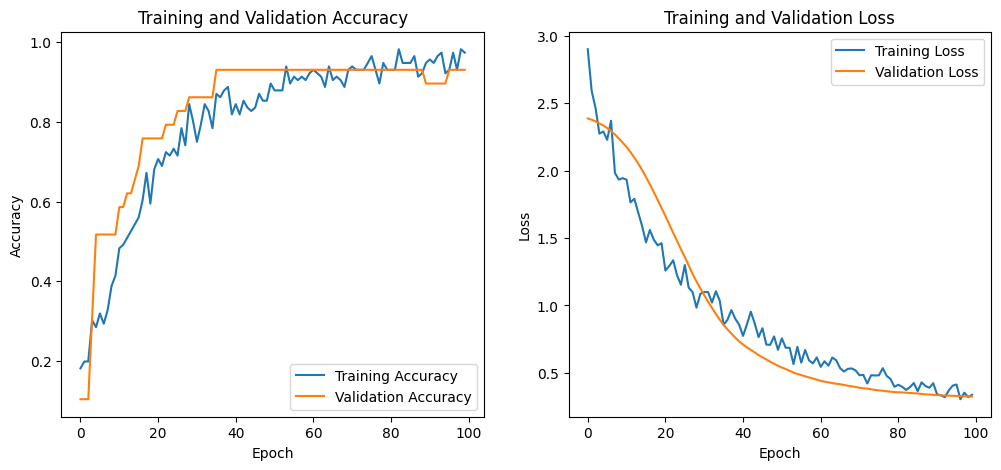

In [ ]:
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9716 - loss: 0.3251
Test Loss: 0.3222663998603821, Test Accuracy: 0.9729729890823364
Test Accuracy: 97.30%


In [ ]:
model.save('mewah_fix.h5')

# Testing dengan Filter

In [ ]:
# Fungsi untuk merekomendasikan barang berdasarkan budget
def recommend_items(budget, tolerance=0.1, top_n=5):
    # Tentukan rentang harga berdasarkan toleransi
    min_price = budget * (1 - tolerance)
    max_price = budget * (1 + tolerance)

    # Filter data berdasarkan harga25000
    recommendations = data[(data['price'] >= min_price) & (data['price'] <= max_price)]

    # Jika lebih dari top_n, urutkan berdasarkan harga
    if not recommendations.empty:
        recommendations = recommendations.sort_values(
            by=['price'], ascending=True
        ).head(top_n)

    # Jika tidak ada hasil, kembalikan DataFrame kosong
    if recommendations.empty:
        return pd.DataFrame(columns=['Brand','item group', 'merek', 'price'])

    # Menampilkan label asli untuk item group, merek, dan brand
    recommendations['item group'] = item_group_encoder.inverse_transform(recommendations['item group'])
    recommendations['merek'] = merek_encoder.inverse_transform(recommendations['merek'])

    return recommendations[['Brand','item group', 'merek', 'price']]

# Contoh Penggunaan: User memberikan budget
example_budget = float(input("Masukkan anggaran Anda (dalam IDR): "))
recommendations = recommend_items(example_budget)

if not recommendations.empty:
    print("\nRekomendasi Barang yang Sesuai dengan Budget Anda:")
    print(recommendations)
else:
    print("Tidak ada barang yang sesuai dengan anggaran Anda.")


Masukkan anggaran Anda (dalam IDR): 2000000

Rekomendasi Barang yang Sesuai dengan Budget Anda:
                                                 Brand  item group  \
203  MICHAEL KORS 35T0GBFS5B BEDFORD SMALL DUFFLE S...  WOMEN BAGS   
354  MICHAEL KORS 35T0GBFS5B BEDFORD SMALL DUFFLE S...  WOMEN BAGS   
284  MICHAEL KORS 35T0GBFS5B BEDFORD SMALL DUFFLE S...  WOMEN BAGS   
381  MICHAEL KORS 35T0GBFS5B BEDFORD SMALL DUFFLE S...  WOMEN BAGS   
439  KATE SPADE WKRU6797 MEDIUM TRIPLE COMPARTMENT ...  WOMEN BAGS   

            merek      price  
203  MICHAEL KORS  1850000.0  
354  MICHAEL KORS  1850000.0  
284  MICHAEL KORS  1850000.0  
381  MICHAEL KORS  1850000.0  
439    KATE SPADE  1850000.0  
